In [265]:
import numpy as np

In [266]:
%matplotlib inline

In [267]:
import matplotlib.pyplot as plt

## Load CT volume

In [268]:
from path import Path
import pydicom

ct_dir_path = Path('/mnt/data/olivierv/Cyl/AC_CT_0003/')

In [269]:
%%time
#volume = np.array([pydicom.dcmread(f).pixel_array for f in ct_dir_path.listdir()])

imas = [pydicom.dcmread(f) for f in ct_dir_path.listdir()]

shuffled_volume = np.array([ima.pixel_array for ima in imas])

pos = [int(ima.InstanceNumber) - 1 for ima in imas]

volumect = np.zeros_like(shuffled_volume)

volumect[pos] = shuffled_volume

CPU times: user 404 ms, sys: 112 ms, total: 516 ms
Wall time: 529 ms


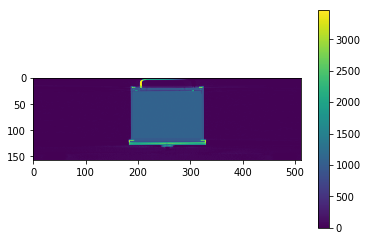

In [270]:
plt.imshow(volumect[:,256])
plt.colorbar()

In [271]:
volumect[0,0,0]

0

## Convert to Hounsfield units

In [272]:
slope, intercept = float(imas[0].RescaleSlope), float(imas[0].RescaleIntercept)

In [273]:
ct_volume_hounsfield = slope*volumect + intercept

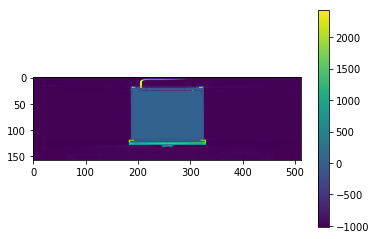

In [274]:
plt.imshow(ct_volume_hounsfield[:,256])
plt.colorbar()

## Convert to µ map

In [275]:
kvp_dict = {"80": 
{
"a": 3.64e-5,
"b": 6.261e-2,
"breakpoint": 50,
},
"100":
{
"a": 4.43e-5,
"b": 5.44e-2,
"breakpoint": 52,
},
"110":
{
"a": 4.92e-5,
"b": 4.88e-2,
"breakpoint": 43,
},
"120":
{
"a": 5.1e-5,
"b": 4.71e-2,
"breakpoint": 47,
},
"130":
{
"a": 5.51e-5,
"b": 4.24e-2,
"breakpoint": 37,
},
"140":
{
"a": 5.64e-5,
"b": 4.08e-2,
"breakpoint": 30,
},
}
def affine_attenuation_conversion(volume, breakpoint, a, b):
    attenuation = np.zeros_like(volume, dtype=np.float)
    small = volume < breakpoint
    attenuation[small] = (volume[small] + 1000)*(9.6e-5)
    attenuation[~small] = a*(volume[~small] + 1000) + b
    attenuation[attenuation < 0] = 0
    return attenuation

def attenuation_correction(volume, kvp):
    return affine_attenuation_conversion(volume, **kvp_dict[kvp])

In [276]:
kvp_dict["120"]

{'a': 5.1e-05, 'b': 0.0471, 'breakpoint': 47}

In [277]:
attenuation_volume = attenuation_correction(ct_volume_hounsfield, kvp=str(imas[0].KVP))

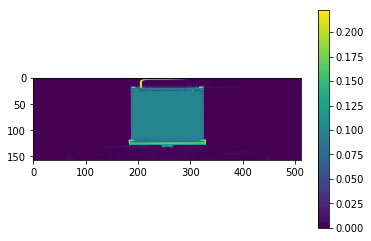

In [278]:
plt.imshow(attenuation_volume[:,256,:])
plt.colorbar()

## Load PET data

In [432]:
bed_position = 2

In [433]:
from pathlib import Path

In [434]:
base_path = Path("/mnt/data/olivierv/")

In [435]:
data_path = base_path / "Decompressed"

In [436]:
import numpy as np

In [437]:
sino_arrays = [ np.load(data_path / 'P0{}.npy'.format(i)) for i in range(3)]

In [438]:
header_paths = [data_path / 'P0{}.s.hdr'.format(i) for i in range(3)]

In [439]:
sino = sino_arrays[bed_position]

In [440]:
data  = (sino[...,::2] + sino[...,1::2])/2

## Fetch bed position in mm

In [441]:
def get_bed_position_mm(bed_position):
    with open(header_paths[bed_position]) as f:
        for line in f:
            if line.startswith('start horizontal bed position'):
                value = float(line[36:])
                return value

In [442]:
bed_position_mm = get_bed_position_mm(bed_position)

## Registration

In [443]:
def get_attenuation_slice(ct_volume, offset, thickness=226.72):
    """
    ct_volume: odl volume, z coordinate first
    """
    pixel_thickness = ct_volume.space.cell_sides[0]
    ct_space= ct_volume.space
    length_from_left = (offset - ct_space.min_pt[0])
    slice_offset = int(length_from_left/pixel_thickness)
    span = int(thickness/pixel_thickness)
    ct_slice = ct_volume[slice_offset:slice_offset+span]
    padded_ct_slice = np.zeros((span, ct_volume.shape[1], ct_volume.shape[2]))
    padded_ct_slice[:len(ct_slice)] = ct_slice
    min_pt, max_pt = ct_volume.space.min_pt, ct_volume.space.max_pt
    slice_space = odl.discr.uniform_discr(min_pt=[0, min_pt[1], min_pt[2]], max_pt=[thickness ,max_pt[1], max_pt[2]], shape=padded_ct_slice.shape)
    return slice_space.element(padded_ct_slice)

In [444]:
distance_constant = 252 + (-576)

In [445]:
print(distance_constant)

-324


In [446]:
def get_ct_offset(bed_position, distance=-324):
    """
    bed_position is the interfile key is "start horizontal bed position (mm)"
    """
    return -bed_position + distance

In [447]:
import odl

In [448]:
get_ct_offset(bed_position_mm)

1.009999999999991

In [449]:
ct_space = odl.discr.uniform_discr([-40.5, -400, -400], [430.5, 408, 408], volumect.shape)

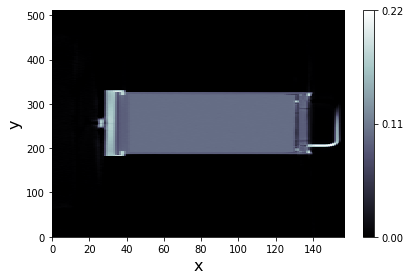

<Figure size 432x288 with 0 Axes>

In [450]:
ct_space.element(attenuation_volume[::-1])[:,256].show();

In [451]:
attenuation_slice = get_attenuation_slice(ct_space.element(attenuation_volume[::-1]), get_ct_offset(bed_position_mm))

In [452]:
attenuation_slice.space

uniform_discr([   0., -400., -400.], [ 226.72,  408.  ,  408.  ], (76, 512, 512))

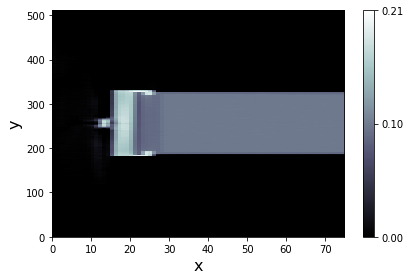

<Figure size 432x288 with 0 Axes>

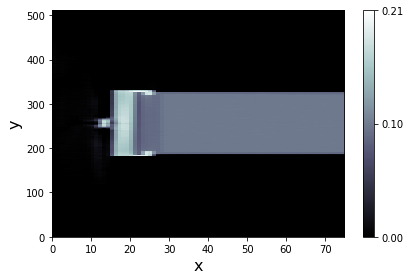

In [453]:
attenuation_slice[:,256].show()

## Reconstruction

### PET Projector

In [23]:
from odlpet import Compression, Scanner

In [24]:
%run mct.py

In [25]:
c = Compression(mCT())

In [9]:
c.num_of_views = 168
#c.num_non_arccor_bins = 400
c.num_non_arccor_bins = 200
c.data_arc_corrected = True
c.span_num = 11
# the following is new:
c.max_num_segments = 45

In [30]:
c.get_num_tangential()

312

In [459]:
#proj = c.get_projector(stir_domain=c.get_stir_domain(sizes=(109,200,200)), restrict_to_cylindrical_FOV=False)
#proj = c.get_projector(stir_domain=c.get_stir_domain(zoom=.5),restrict_to_cylindrical_FOV=False)
proj = c.get_projector(stir_domain=c.get_stir_domain(sizes=(28,101,101),zoom=.5),restrict_to_cylindrical_FOV=False)

In [460]:
proj.domain

uniform_discr([   0., -400., -400.], [  58.24,  408.  ,  408.  ], (28, 101, 101), dtype='float32')

## Resampling

In [461]:
dummy_space = odl.discr.lp_discr.uniform_discr(min_pt=proj.domain.min_pt, max_pt=proj.domain.max_pt, shape=attenuation_slice.shape)

In [462]:
sampled_attenuation_slice = proj.domain.element(dummy_space.element(attenuation_slice).interpolation)

In [463]:
#sampled_attenuation_slice = proj.domain.element(attenuation_slice.interpolation)

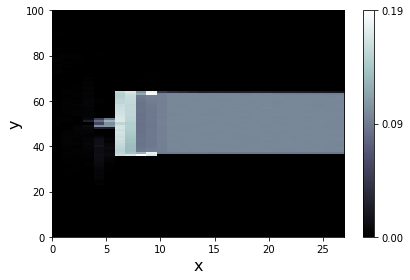

<Figure size 432x288 with 0 Axes>

In [499]:
sampled_attenuation_slice[:,50].show();

In [465]:
def get_attenuation_multiplicator(operator, attenuation_volume):
    pixel_size = operator.domain.cell_sides[1]
    #pixel_size = operator.domain.cell_sides
    atn_proj = operator(attenuation_volume)
    return np.exp(-atn_proj*pixel_size/10)

In [466]:
proj.domain.cell_sides

array([ 2.07999986,  8.        ,  8.        ])

In [467]:
%%time
attenuation_multiplicator = get_attenuation_multiplicator(proj, sampled_attenuation_slice)

CPU times: user 16.1 s, sys: 404 ms, total: 16.5 s
Wall time: 15.8 s


## Reconstruction

In [468]:
attenuated_data = data/attenuation_multiplicator

In [29]:
attenuated_data

NameError: name 'attenuated_data' is not defined

In [469]:
reco0 = proj.domain.one()

In [470]:
mlem = odl.solvers.iterative.statistical.mlem

In [471]:
iters = 2

In [472]:
%%time
mlem(proj, reco0, attenuated_data, niter=iters)

CPU times: user 1min 5s, sys: 488 ms, total: 1min 5s
Wall time: 1min 1s


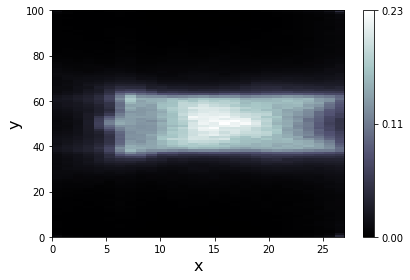

<Figure size 432x288 with 0 Axes>

In [500]:
reco0[:,51].show();#clim=[0.,0.5])

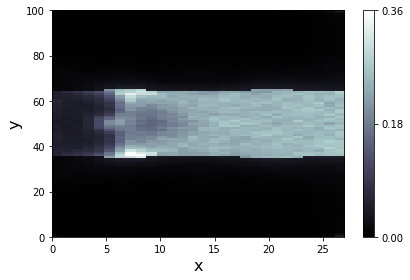

<Figure size 432x288 with 0 Axes>

In [501]:
reco_c = reco0*sensitivity
reco_c[:,51].show();

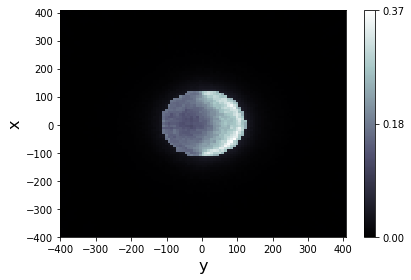

<Figure size 432x288 with 0 Axes>

In [502]:
reco_c.show(coords=[20,None,None]);

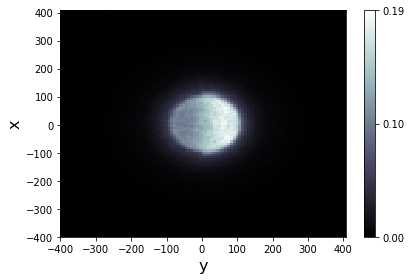

<Figure size 432x288 with 0 Axes>

In [503]:
reco0.show(coords=[20,None,None]);

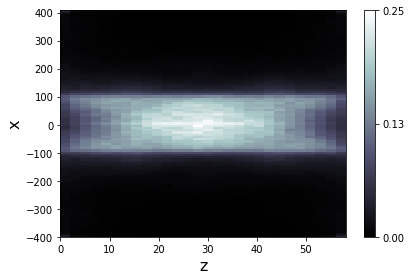

<Figure size 432x288 with 0 Axes>

In [504]:
reco.show(coords=[None,0,None]);

In [194]:
sensitivity = proj.domain.one()
mask = reco.asarray() >= 0.01
sensitivity[mask]= np.max(reco)/reco[mask]


In [491]:
mask2 = sensitivity.asarray() >= 5.
sensitivity[mask2]= 1


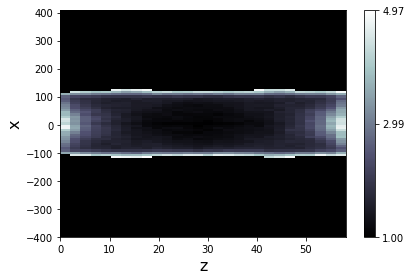

<Figure size 432x288 with 0 Axes>

In [505]:
sensitivity.show(coords=[None,0,None]);

### Save Reconstruction

In [ ]:
save_dir = base_path / "cylrecosatn"

In [ ]:
save_path = save_dir / "reco-{}-{}-{}.npy".format(bed_position, reco.shape[1], iters)

In [287]:
print(save_path)

/mnt/data/olivierv/cylrecosatn/reco-1-101-2.npy


In [288]:
np.save(save_path, reco)